In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
# Load data
train = pd.read_csv("training_data.csv")
test = pd.read_csv("songs_to_classify.csv")
train.shape, test.shape

((750, 14), (200, 13))

In [3]:
# Inspect data
train.sample(5)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
131,0.37300,0.653,174785,0.660,0.000000,6,0.6840,-4.966,1,0.0511,87.958,4,0.677,1
508,0.28500,0.771,276160,0.676,0.000004,4,0.5460,-6.018,0,0.2230,119.997,4,0.804,0
403,0.72900,0.401,292280,0.351,0.000000,0,0.0702,-12.597,1,0.0438,160.145,3,0.380,1
89,0.00686,0.764,212707,0.906,0.000000,7,0.2570,-6.041,0,0.0523,128.043,4,0.575,1
101,0.11000,0.731,193467,0.748,0.000000,1,0.3250,-5.115,1,0.0443,94.965,4,0.836,0


# Preprocess
Plots the histograms of all the features to visualize the training data. Then plotting a scatter matrix for combinations of features, indented to select features from this.

In [4]:
# All features
FEATURE_KEYS = ['acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'label']

In [5]:
def draw_histograms(df, variables, n_rows, n_cols, feat_keys=FEATURE_KEYS):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(ax=ax)
        ax.set_title(f"{feat_keys[var_name]}")
    fig.tight_layout()
    plt.show()

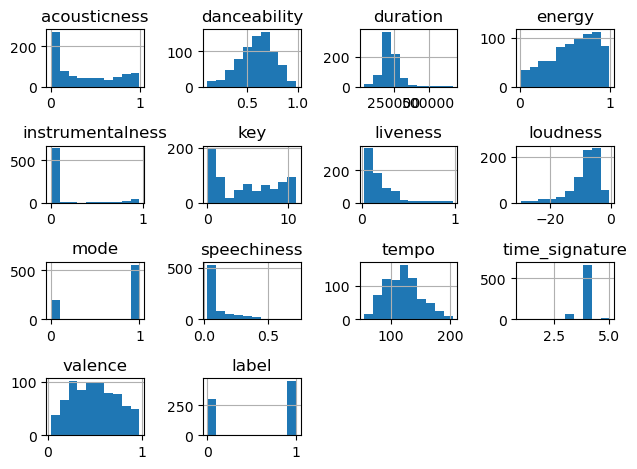

In [6]:
test_data_frame = pd.DataFrame(train.values)
draw_histograms(test_data_frame, test_data_frame.columns, 4, 4)

['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'label']


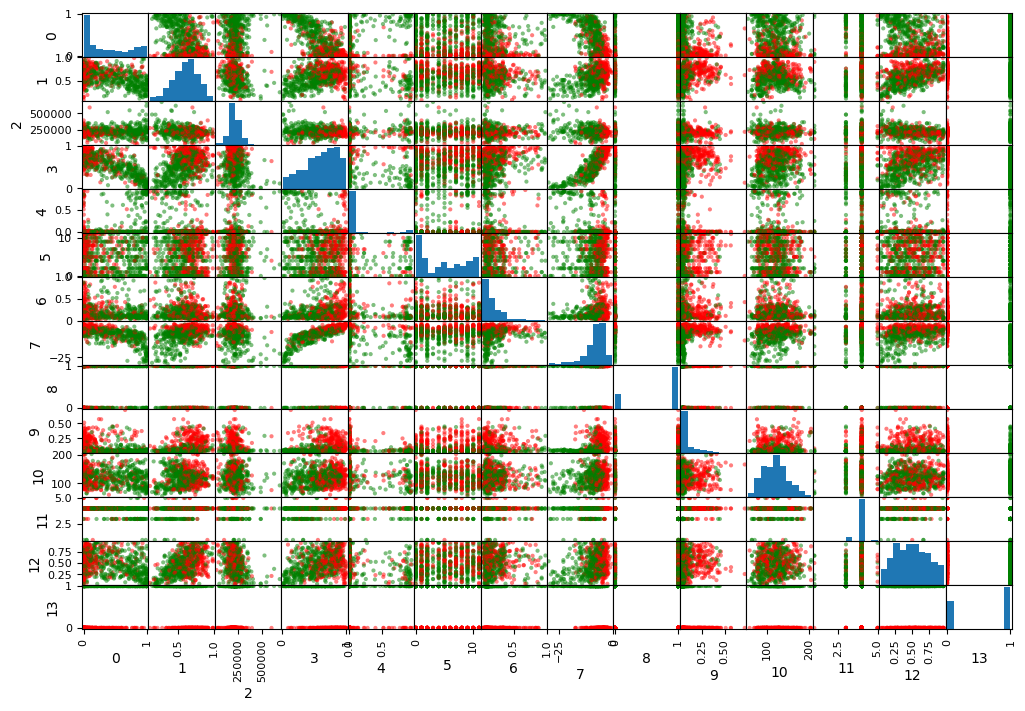

In [7]:
test_data_frame2 = pd.DataFrame(train.values)
colMap={0:"red", 1:"green"}
cols = list(map(lambda x:colMap.get(x), train.loc[:,'label'].values))
scatter_matrix(test_data_frame2, diagonal='hist', c=cols, figsize=(12,8))
print(FEATURE_KEYS)

## Notes from plots
- Acousticness, good spread
- Danceability, good spred and similar to normal distribution
- Duration, a few outliers
- Energy, good spread
- Instrumentalness, most of the datapoints are $\approx 0$
- Key, good spread
- Liveness, uneven, outliers might be problematic, inverse exponential
- Loudness, similar to Liveness and Duration, a few outliers
- Mode, might be good, two distinct categories with $\approx$ double the amount of datapoints on 1
- Speechiness, bad spread, like instrumentalness
- Tempo, good spread
- Time Signature, almost all datapoints are at the same level
- Valence, good spread
- Label, almost the same amount of good and bad, a little more of likes.

I ended up not filtering out outliers and just using all features since I saw a major boost in performance, evaluated with cross validation, when using all features compared to 4-5 features selected using above plots.

In [8]:
# Choses features
features = ['acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']

X_train = train.loc[:,features].values
y_train = train.loc[:,'label'].values

X_test = test.loc[:,features].values

['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


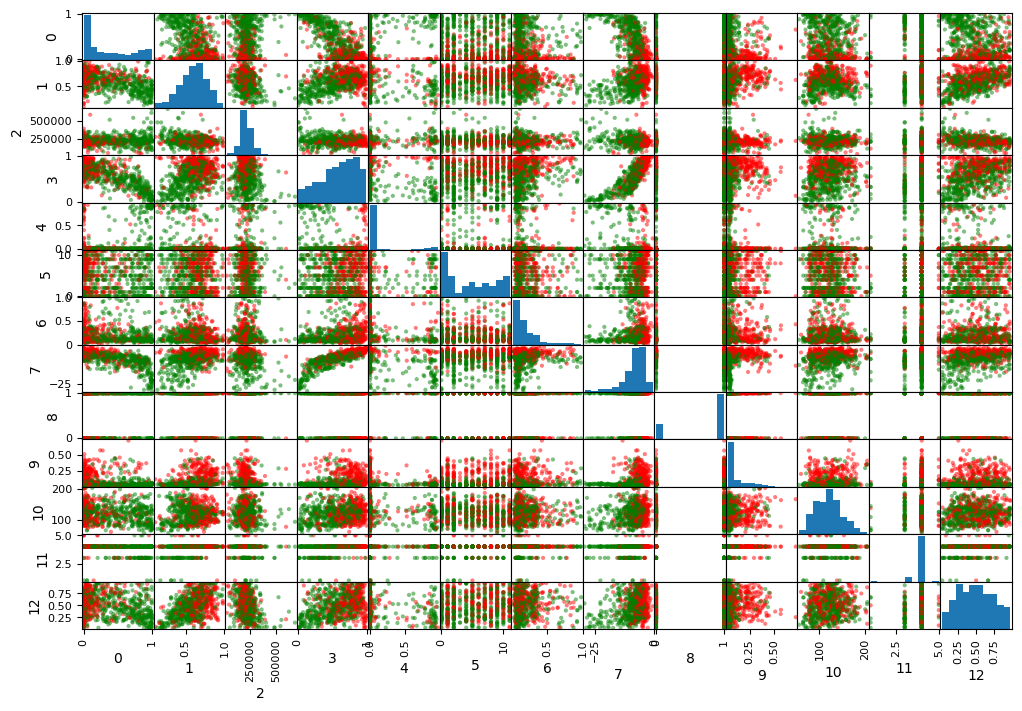

In [9]:
test_data_frame3 = pd.DataFrame(X_train)
colMap = {0:"red", 1:"green"}
cols = list(map(lambda x:colMap.get(x), y_train))
scatter_matrix(test_data_frame3, diagonal='hist', c=cols, figsize=(12,8))
print(features)

## Scaling

[Source](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section)

StandardScaler and MinMaxScaler are sensitive to outliers but MinMax compresses inliers into a narrow range and the standard scale is used as input for some models so StandardScaler is chosen.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_trainn = scaler.transform(X_train)
X_testn = scaler.transform(X_test)

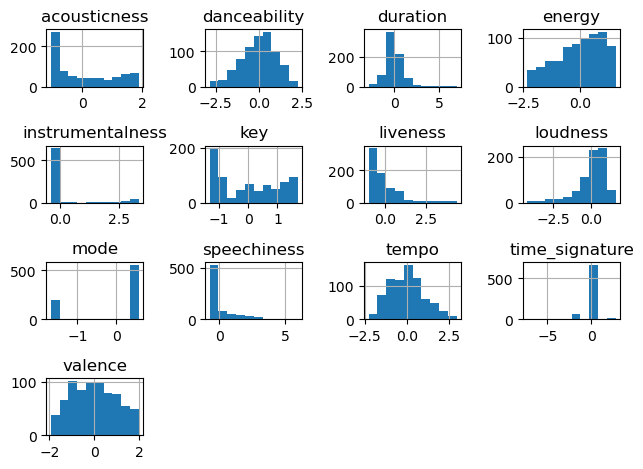

In [11]:
test_data_fram = pd.DataFrame(X_trainn)
draw_histograms(test_data_fram, test_data_fram.columns, 4, 4, feat_keys=features)

['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


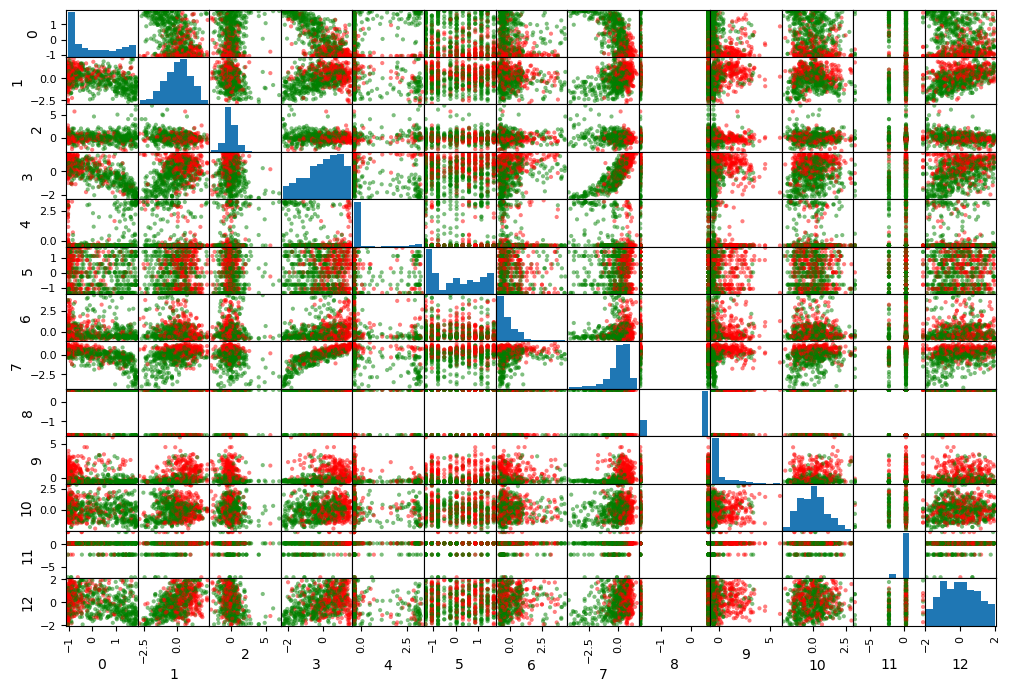

In [12]:
test_data_frame4 = pd.DataFrame(X_trainn)
colMap={0:"red", 1:"green"}
cols = list(map(lambda x:colMap.get(x), y_train))
scatter_matrix(test_data_frame4, diagonal='hist', c=cols, figsize=(12,8))
print(features)

In [13]:
# Help method for crossvalidation
def cross_val_print_thing(model, k_fold=5):
    scores = cross_val_score(model, X_trainn, y_train, cv=k_fold, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    return (mean_score, std_score)

# Models

## K-NN
The k-Nearest Neighbors (kNN) classification model is a type of instance-based learning algorithm in machine learning. It operates on the principle that similar things exist in close proximity.

1. **Distance Calculation**: The algorithm calculates the distance between the new data point and all the existing data points. How the distance is calculated can be selected, such as Euclidean or Manhattan distance.

2. **Choosing 'k' Neighbors**: The algorithm then selects the 'k' data points that are closest to the new data point. 'k' is a user-defined constant.

3. **Majority Voting**: Among these 'k' neighbors, the algorithm identifies the number of data points in each category.

4. **Assignment**: The new data point is assigned to the category where the majority of the 'k' neighbors belong.

The kNN model is simple and effective, making it a popular choice for tasks such as image recognition, text categorization, and **recommendation systems**.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
n_neighs = []
mean_scores = []
std_scores = []

# Loop over a reasonable amount of neighbors to find the best one
for n in range(1, 100):
    knnmodel = KNeighborsClassifier(n_neighbors=n, p=2)
    knnmodel.fit(X_trainn, y_train)

    # Evaluate it
    (mean, std) = cross_val_print_thing(knnmodel)
    # Save this instance
    n_neighs.append(n)
    mean_scores.append(mean)
    std_scores.append(std)

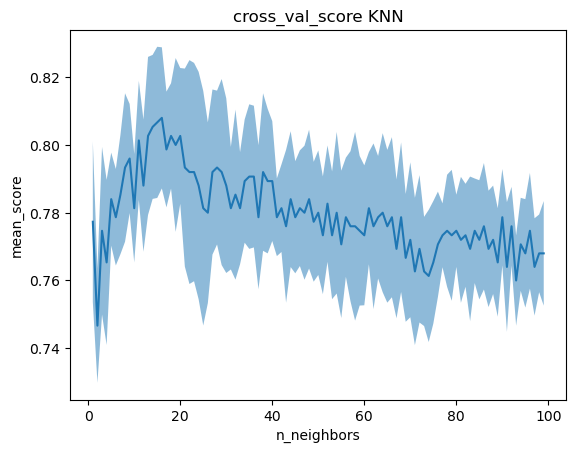

Best n_neighbors: 16 with 0.8080 mean


In [16]:
std_print = (np.add(mean_scores, std_scores), np.subtract(mean_scores, std_scores))

fig, ax = plt.subplots()

ax.plot(n_neighs, mean_scores)
ax.fill_between(n_neighs, std_print[0], std_print[1], alpha=0.5, linewidth=0)
#ax.set(ylim=(0.5, 1))
plt.xlabel("n_neighbors")
plt.ylabel("mean_score")
plt.title("cross_val_score KNN")
plt.show()

# Save the best result for the final model
best_mean = np.max(mean_scores)
best_n = n_neighs[np.argmax(mean_scores)]
print(f"Best n_neighbors: {best_n} with {best_mean:.4f} mean")

In [17]:
# Create the final model
knnmodel = KNeighborsClassifier(n_neighbors=best_n)
knnmodel.fit(X_trainn, y_train)
(mean, std) = cross_val_print_thing(knnmodel)
print(f"Mean: {mean:.4f}\nstd: {std:.4f}")

Mean: 0.8080
std: 0.0208


In [18]:
# make predictions
predictions = knnmodel.predict(X_testn)
pred_str = f"{predictions}".replace(" ", "").replace("[", "").replace("]", "").replace("\n", "")

# save prediction
file2write=open("knnprediction.txt",'w')
file2write.write(pred_str)
file2write.close()

print(pred_str)

00010101101111001111001100101110011011000101010110011101100011001111101111110110111101101010001011111111010111111011111001101100101111111111101011001011001111101100100110111100011011111110100010100111


## Logistic Regression
Logistic Regression is a **statistical** model used in machine learning for binary classification problems. It uses the logistic function to model the probability of a certain class or event.

- **Model**: Logistic Regression estimates the probability that an instance belongs to a particular class. If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class, and otherwise it predicts that it does not. This makes it a binary classifier.

- **Function**: The logistic function, also called the sigmoid function, is an S-shaped curve that maps any real-valued number to a value between 0 and 1. It is defined as:
    $$f(x) = \frac{1}{1 + e^{-x}}$$

- **Decision Boundary**: Logistic regression makes predictions based on the concept of a decision boundary, a threshold over which an instance is classified into one class or another.

- **Training**: During training, the algorithm adjusts the model parameters to maximize the likelihood of the positive instances (and consequently minimize the likelihood for the negative instances), a process called Maximum Likelihood Estimation.

- **Multiclass Classification**: While it is a binary classification algorithm at its core, logistic regression can be extended to multiclass classification through techniques like one-vs-all or one-vs-one.

- **Pros & Cons**: Logistic regression is simple, fast, and provides probabilities for predictions. However, it may underperform when there are multiple or non-linear decision boundaries. It's not powerful enough to capture more complex relationships.

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
Cs = []
mean_scores = []
std_scores = []

# Loop over c to find the best parameter
for c in range(1, 1000):
    log_model = LogisticRegression(C=c/1000, solver='newton-cholesky')
    log_model.fit(X_trainn, y_train)

    # Evaluate
    (mean, std) = cross_val_print_thing(log_model)
    # Save evaluation
    Cs.append(c/1000)
    mean_scores.append(mean)
    std_scores.append(std)

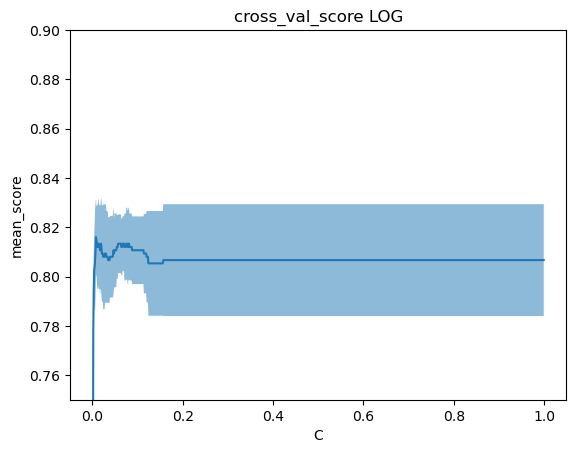

Best C: 0.008 with 0.8160 mean


In [21]:
std_print = (np.add(mean_scores, std_scores), np.subtract(mean_scores, std_scores))

fig, ax = plt.subplots()

ax.plot(Cs, mean_scores)
ax.fill_between(Cs, std_print[0], std_print[1], alpha=0.5, linewidth=0)
ax.set(ylim=(0.75, 0.9))
plt.xlabel("C")
plt.ylabel("mean_score")
plt.title("cross_val_score LOG")
plt.show()

# Save the best performer for the final model
best_mean = np.max(mean_scores)
best_C = Cs[np.argmax(mean_scores)]
print(f"Best C: {best_C} with {best_mean:.4f} mean")

In [22]:
# Create the final model
log_model = LogisticRegression(C=best_C)
log_model.fit(X_trainn, y_train)
(mean, std) = cross_val_print_thing(log_model)
print(f"Mean: {mean:.4f}\nstd: {std:.4f}")

Mean: 0.8160
std: 0.0155


In [23]:
# make predictions
predictions = log_model.predict(X=X_testn)
pred_str = f"{predictions}".replace(" ", "").replace("[", "").replace("]", "").replace("\n", "")

# save prediction
file2write=open("logprediction.txt",'w')
file2write.write(pred_str)
file2write.close()

print(pred_str)

01010111101101101011001100110011011111010101010110001101100011000111101111110110110101111010011011111111010111110111101101101111101011111101100011001011001111100101101110111000111001111110100111100111


## Decision Tree
A **Decision Tree** is a supervised machine learning model used for classification and regression tasks.

- **Structure**: The decision tree model predicts the value of a target variable by learning simple decision rules inferred from the data features. It's called a "tree" because it starts with a single box (or root), which then branches off into a number of solutions, just like a tree.

- **How it works**: Each internal node of the tree corresponds to an attribute, and each leaf node corresponds to a class label. The topmost node in a tree is called the root node. It learns to partition on the basis of the attribute value. It partitions recursively in such a manner called recursive partitioning.

- **Advantages**: Decision Trees are easy to understand and interpret, require relatively little effort for data preparation, and **can handle both numerical and categorical data**.

- **Disadvantages**: They can easily overfit or underfit the dataset, leading to poor predictive performance. They can also be unstable because small variations in the data might result in a completely different tree being generated.

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
criterions = []
max_depths = []
min_samples_splits = []
min_samples_leafs = []
random_states = []

mean_scores = []
std_scores = []

# Loop over the expected best value with variation to find a good one
for criterion in ['gini', 'entropy', 'log_loss']:
    for max_depth in range(7-2, 7+2):
        for min_samples_split in range(26-2, 26+2):
            for min_samples_leaf in range(12-2, 12+2):
                for random_state in range(2-2, 2+2):
                    tree_model = DecisionTreeClassifier(
                        criterion=criterion, 
                        max_depth=max_depth, 
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=random_state,
                        )
                    tree_model.fit(X_trainn, y_train)

                    # Evaluate
                    (mean, std) = cross_val_print_thing(tree_model)
                    # Save evaluation
                    criterions.append(criterion)
                    max_depths.append(max_depth)
                    min_samples_splits.append(min_samples_split)
                    min_samples_leafs.append(min_samples_leaf)
                    random_states.append(random_state)
                    mean_scores.append(mean)
                    std_scores.append(std)

In [26]:
# Save the best parameters for the final model
# Note: the random_state != 0 makes the model better but less predictable 
# and might get different results when run, therefore the best model might just be the lucky one.
best_mean = np.max(mean_scores)
argmax_mean = np.argmax(mean_scores)
best_criterion = criterions[argmax_mean]
best_max_depth = max_depths[argmax_mean]
best_min_samples_leaf = min_samples_leafs[argmax_mean]
best_min_samples_split = min_samples_splits[argmax_mean]
best_random = random_states[argmax_mean]

best_criterion = criterions[np.argmax(mean_scores)]

print(f"Best mean:{best_mean:.4f}")
print(f"Criterion: {best_criterion}")
print(f"Depth: {best_max_depth}")
print(f"Leaf: {best_min_samples_leaf}")
print(f"Split: {best_min_samples_split}")
print(f"Random: {best_random}")

Best mean:0.8213
Criterion: gini
Depth: 7
Leaf: 12
Split: 26
Random: 2


In [27]:
# Create the final model, suggested to be done until the mean printed below is sufficient.
tree_model = DecisionTreeClassifier(
                        criterion=best_criterion, 
                        max_depth=best_max_depth, 
                        min_samples_split=best_min_samples_split,
                        min_samples_leaf=best_min_samples_leaf,
                        random_state=best_random,
                        )
tree_model.fit(X_trainn, y_train)
(mean, std) = cross_val_print_thing(log_model)
print(f"Mean: {mean:.4f}\nstd: {std:.4f}")

Mean: 0.8160
std: 0.0155


In [28]:
# make predictions
predictions = tree_model.predict(X=X_testn)
pred_str = f"{predictions}".replace(" ", "").replace("[", "").replace("]", "").replace("\n", "")

# save prediction
file2write=open("treeprediction.txt",'w')
file2write.write(pred_str)
file2write.close()

print(pred_str)

11110011101111111011101000001111011111000101111110011101100111100111001111110110110001111000101011111110110111111010101101111110101001111111101011011011011111111101111111111101011011111110101111110111


## Forest
A **Random Forest** is also a supervised machine learning model used for both classification and regression.

- **Ensemble of Decision Trees**: Random Forest is an ensemble learning method that operates by constructing multiple decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

- **How it works**: Random forests create decision trees on randomly selected data samples, get predictions from each tree, and select the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

- **Advantages**: Random forests are highly accurate and robust due to the number of decision trees participating in the process. It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.

- **Disadvantages**: The main limitation of the Random Forests algorithm is that a large number of trees can make the algorithm slow for real-time prediction.

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
treeeeees = []
mean_scores = []
std_scores = []

# Loop over a large span of number of trees to get a picture of where the best is
# This can take some time, have faith (or print statement ☺)
for n_trees in range(25, 400, 25):
    forest_classifier = RandomForestClassifier(n_estimators=n_trees)
    forest_classifier.fit(X_trainn, y_train)

    # Evaluate
    (mean, std) = cross_val_print_thing(forest_classifier)
    # Save evaluation
    treeeeees.append(n_trees)
    mean_scores.append(mean)
    std_scores.append(std)

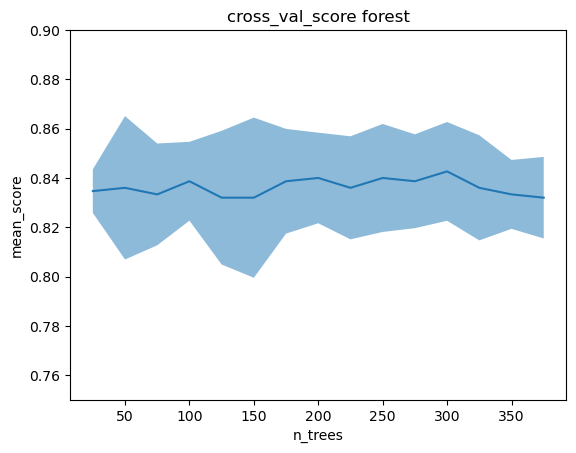

Best n_trees: 300 with 0.8427 mean


In [31]:
fig, ax = plt.subplots()

std_print = (np.add(mean_scores, std_scores), np.subtract(mean_scores, std_scores))
ax.plot(treeeeees, mean_scores)
ax.fill_between(treeeeees, std_print[0], std_print[1], alpha=0.5, linewidth=0)
ax.set(ylim=(0.75, 0.9))
plt.xlabel("n_trees")
plt.ylabel("mean_score")
plt.title("cross_val_score forest")
plt.show()

# Save the best for the final model
best_mean = np.max(mean_scores)
best_treees = treeeeees[np.argmax(mean_scores)]
print(f"Best n_trees: {best_treees} with {best_mean:.4f} mean")

### Note from plot
The mean seems to be relatively stable, so the best number of trees parameter can vary greatly between runs.

In [32]:
# Create the final model, suggested to be done until the mean printed below is sufficient.
# Just like the tree, the forest differs from run to run.
forest_classifier = RandomForestClassifier(n_estimators=best_treees)
forest_classifier.fit(X_trainn, y_train)
(mean, std) = cross_val_print_thing(forest_classifier, k_fold=5)
print(f"Mean: {mean:.4f}\nstd: {std:.4f}")

Mean: 0.8413
std: 0.0186


In [33]:
# make predictions
predictions = forest_classifier.predict(X=X_testn)
pred_str = f"{predictions}".replace(" ", "").replace("[", "").replace("]", "").replace("\n", "")

# save prediction
file2write=open("forestprediction.txt",'w')
file2write.write(pred_str)
file2write.close()

print(pred_str)

00010011001101101011001100000111011111010101110110001101100011100111101011110110110101110000011011111010010111110010101001111110101011111111101011001010001111101101111111111000011011111110100111100111


# Summary or method to the madness
I chose to evaluate the k-NN, log-reg, decision tree and random forests since they are relatively simple yet sufficiently different for me to learn something (and comparing them making sense).

I ultimately chose to go with the random forest classifier since it is an ensemble on trees which have very good characteristics for this application. Being able to handle both numerical and categorical data with minimal data preparation and using the ensemble method minimise the bias and not worrying about overfitting.

## My evaluation of the methods
### k-NN
This method is nice because of its simplicity but I think it would shine brighter with a multiclass problem. It did not perform well enough for my purposes and this application.
### log-reg
The logistic method is not good at capturing a more complex relationship, which I would argue that this application and features are. It performed worse than I hoped and not well enough for this application.
### Decision tree
A decision tree is explainable, which is important in a lot of settings, and very simple, both to understand and to use. It can capture more complex relationships but suffers from overfitting/bias. I like this method but as a part of an ensemble model.
### Random forest
The random forest is basically a decision tree but without the overfitting/bias problem. I love this model because it is so simple and performant. Even if it is a little slow...

## What I would do differently
If i did this again, I would do something to combat outliers and preprocess the data more for the first two methods. Some features had categorical nature and might have affected the results of the first two methods.

I was plannig on evaluating a voting classifier of all the models tested but did not have time. Boosting was also on my list, hoping to get even better ensemble results.

Also, visualising the models, with graphs of the trees for example, would have been nice. For learning and explainability purposes but also for validating that the model does roughly what is expected.

## Conclusions
- Ensemble methods are great 😄
- Explainability is something I value greatly